# AlexNet

In this notebook we will be implementing a modified version of [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf), a neural network model that uses convolutional neural network (CNN) layers and was designed for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/). AlexNet is famous for winning the ImageNet challenge in 2012 by beating the second place competitor by over 10% accuracy and kickstarting the interest in deep learning for computer vision.

We are now moving on from the MNIST dataset and from now on we will be using the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. CIFAR10 consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. 

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/cifar10.png?raw=1)



Like the previous notebooks we'll implement our model, measure its performance on the dataset, and then have a short look into seeing what the model has learned.

Most of this notebook will be similar to the previous ones thus we will skim over code that has been shown before. We can look at the previous notebook for a refresher if needed.

### Data Processing

As always, we'll import the modules we need. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

We set the random seed so all of our experiments can be reproduced.

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We calculate the mean and standard deviation of our data so we can normalize it.

Our dataset is made up of color images but three color channels (red, green and blue), compared to MNIST's black and white images with a single color channel. To normalize our data we need to calculate the means and standard deviations for each of the color channels independently. 

To do this we pass a tuple containing the axes we want to take the means and standard deviations over to the `mean` and `std` functions and we receive a list of means and standard deviations for each of the three color channels.

In [3]:
ROOT = '.data'

train_data = datasets.CIFAR10(root=ROOT,
                              train=True,
                              download=True)

means = train_data.data.mean(axis=(0, 1, 2)) / 255
stds = train_data.data.std(axis=(0, 1, 2)) / 255

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Files already downloaded and verified
Calculated means: [0.49139968 0.48215841 0.44653091]
Calculated stds: [0.24703223 0.24348513 0.26158784]


Next up is defining the transforms for data augmentation. 

The images in the CIFAR10 dataset are significantly more complex than the MNIST dataset. They are larger, have three times the amount of pixels and are more cluttered. This makes them harder to learn and consequently means we should use less augmentation.

A new transform we use is `RandomHorizontalFlip`. This, with a probability of `0.5` as specified, flips the image horizontally. So an image of a horse facing to the right will be flipped so it will face to the left. We couldn't do this in the MNIST dataset as we are not expecting our test set to contain any flipped digits, however natural images, such as those in the CIFAR10 dataset, can potentially be flipped as they still make visual sense.

As our `means` and `stds` are now already in lists we do not need to enclose them in lists as we did for the single channel images in the MNIST dataset.

In [4]:
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding=2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

Next, as standard, we'll load the dataset with our transforms...

In [5]:
train_data = datasets.CIFAR10(ROOT,
                              train=True,
                              download=True,
                              transform=train_transforms)

test_data = datasets.CIFAR10(ROOT,
                             train=False,
                             download=True,
                             transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


...create a validation set from our training set...

In [6]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

...and ensure our validation set uses the test transforms.

In [7]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

We print out the number of examples in each set of data to ensure everything has gone OK so far.

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [9]:
BATCH_SIZE = 256

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

### Defining the Model

Next up is defining the model. The image below shows the architecture of AlexNet.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/alexnet.png?raw=1)




In [10]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

We'll create an instance of our model with the desired amount of classes.

In [11]:
OUTPUT_DIM = 10

model = AlexNet(OUTPUT_DIM)

Then we'll see how many trainable parameters our model has. 

Our LeNet architecture had ~44k, but here we have 23.2M parameters - and AlexNet is a relatively small model for computer vision.

### Training the Model


In [12]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

We apply the initialization by using the model's `apply` method. This will call the given function on every module and sub-module within the model.

In [13]:
model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

We can now create a new optimizer with our found learning rate.

Ironically, the learning rate value we found, $0.001$ is actually Adam's default learning rate!

In [14]:
Learning_Rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=Learning_Rate)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)



The rest of the notebook is pretty similar to the previous notebooks from these tutorials.

We define a function to calculate accuracy...

In [15]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...and a function to implement our training loop.

As we are using dropout we need to make sure to "turn it on" when training by using `model.train()`.

In [16]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

We also define an evaluation loop, making sure to "turn off" dropout with `model.eval()`.

In [17]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Then, finally, we train our model.

We get a best validation loss of ~76% accuracy.

In [18]:
EPOCHS = 25

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):


    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'AlexNet-model.pt')


    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 2.617 | Train Acc: 12.49%
	 Val. Loss: 2.055 |  Val. Acc: 20.47%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.775 | Train Acc: 31.92%
	 Val. Loss: 1.623 |  Val. Acc: 40.91%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.474 | Train Acc: 45.82%
	 Val. Loss: 1.364 |  Val. Acc: 50.07%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.338 | Train Acc: 51.43%
	 Val. Loss: 1.226 |  Val. Acc: 56.50%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.246 | Train Acc: 55.40%
	 Val. Loss: 1.161 |  Val. Acc: 59.39%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.160 | Train Acc: 58.70%
	 Val. Loss: 1.070 |  Val. Acc: 62.55%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.095 | Train Acc: 61.31%
	 Val. Loss: 1.032 |  Val. Acc: 63.58%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.032 | Train Acc: 63.91%
	 Val. Loss: 0.988 |  Val. Acc: 65.61%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.982 | Train Acc: 65.75%
	 Val. Loss: 0.923 |  Val. Acc: 67.81%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.949 | Train Acc: 67.32%
	 Val. Loss: 0.869 |  Val. Acc: 70.09%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.906 | Train Acc: 68.26%
	 Val. Loss: 0.877 |  Val. Acc: 68.87%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.875 | Train Acc: 69.43%
	 Val. Loss: 0.848 |  Val. Acc: 71.01%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.842 | Train Acc: 70.85%
	 Val. Loss: 0.822 |  Val. Acc: 71.87%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.820 | Train Acc: 71.84%
	 Val. Loss: 0.825 |  Val. Acc: 71.44%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.796 | Train Acc: 72.46%
	 Val. Loss: 0.810 |  Val. Acc: 72.29%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.774 | Train Acc: 73.22%
	 Val. Loss: 0.786 |  Val. Acc: 72.89%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.754 | Train Acc: 73.80%
	 Val. Loss: 0.763 |  Val. Acc: 73.36%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.736 | Train Acc: 74.60%
	 Val. Loss: 0.774 |  Val. Acc: 73.40%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.712 | Train Acc: 75.55%
	 Val. Loss: 0.738 |  Val. Acc: 74.87%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.697 | Train Acc: 76.17%
	 Val. Loss: 0.745 |  Val. Acc: 75.46%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.678 | Train Acc: 76.71%
	 Val. Loss: 0.763 |  Val. Acc: 74.35%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.670 | Train Acc: 77.03%
	 Val. Loss: 0.723 |  Val. Acc: 75.74%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.651 | Train Acc: 77.58%
	 Val. Loss: 0.724 |  Val. Acc: 75.64%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.642 | Train Acc: 77.97%
	 Val. Loss: 0.723 |  Val. Acc: 75.87%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.632 | Train Acc: 78.59%
	 Val. Loss: 0.750 |  Val. Acc: 74.70%


We then load the parameters of our model that achieved the best validation loss and evaluate this model on the test set to achieve a ~75% accuracy.

In [19]:
model.load_state_dict(torch.load('AlexNet-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.724 | Test Acc: 75.33%


### Examining the Model

We will do the exact same probing into our model as we did in the previous notebooks: plotting a confusion matrix, plotting the most confident incorrect predictions, using PCA and t-SNE, and viewing the learned weights of our model.

First, we'll collect all the predictions.

In [20]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [21]:
images, labels, probs = get_predictions(model, test_iterator, device)

Then, for each prediction we get the predicted class.

In [22]:
pred_labels = torch.argmax(probs, 1)

Next, we plot the confusion matrix. This time we have edited the function to allow us to pass a list of strings which are the labels classes.

In [23]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)

In [24]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

The two classes our model seems to get mixed up the most is cat and dog.

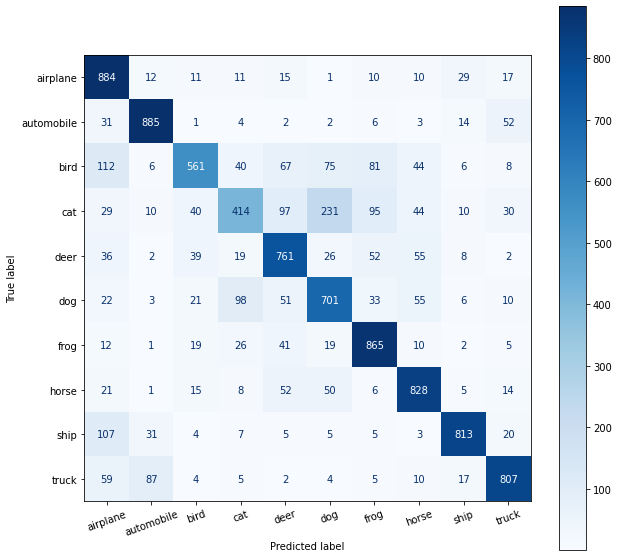

In [25]:
classes = test_data.classes
plot_confusion_matrix(labels, pred_labels, classes)

We can then find which predictions were correct and then sort the incorrect predictions in descending order of their confidence.

In [26]:
corrects = torch.eq(labels, pred_labels)

In [27]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [28]:
def plot_most_incorrect(incorrect, classes, n_images, normalize=True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

Interestingly, the most incorrect was an example that is incorrectly labelled in the dataset itself. It is clearly a frog, which our model predicted with 100% confidence, but the label is cat.

Truck and automobile seem to be confused a lot but even to humans these two classes are slightly ambiguous.

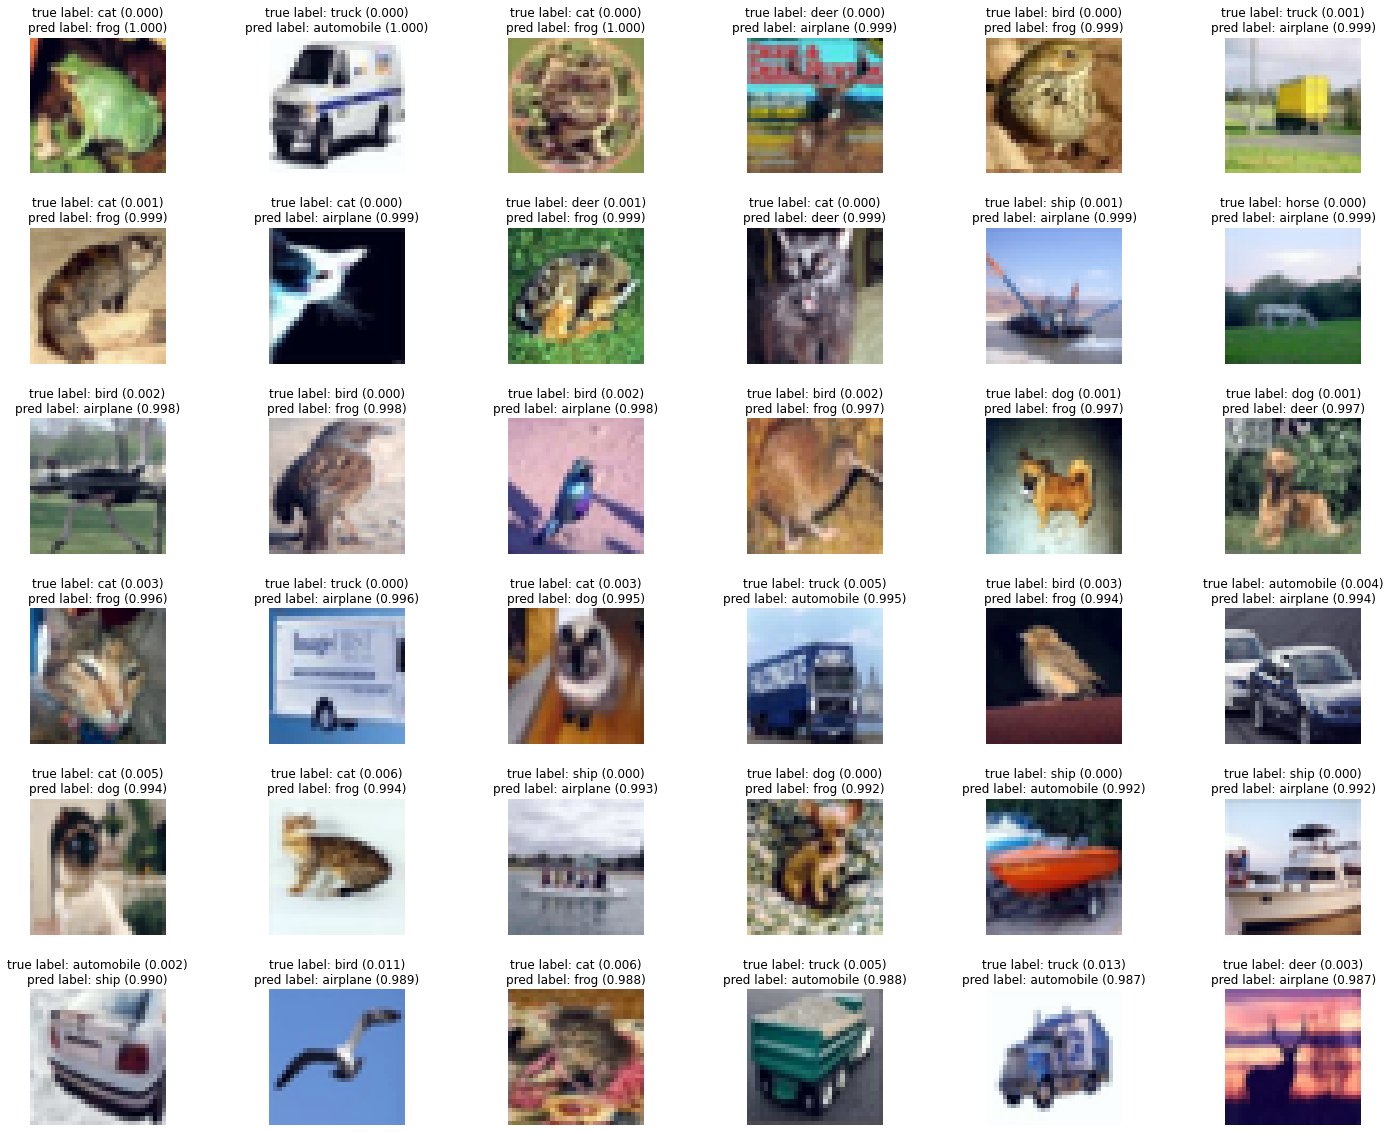

In [29]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

Next, we'll get the output and intermediate (after the flatten) representations.

In [30]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [31]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

  0%|          | 0/176 [00:00<?, ?it/s]

We can then perform PCA on them both and plot them.

In [32]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [33]:
def plot_representations(data, labels, classes, n_images=None):

    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=classes)

Like previous notebooks, the classes seem more separated in the output representations than the intermediate representations.

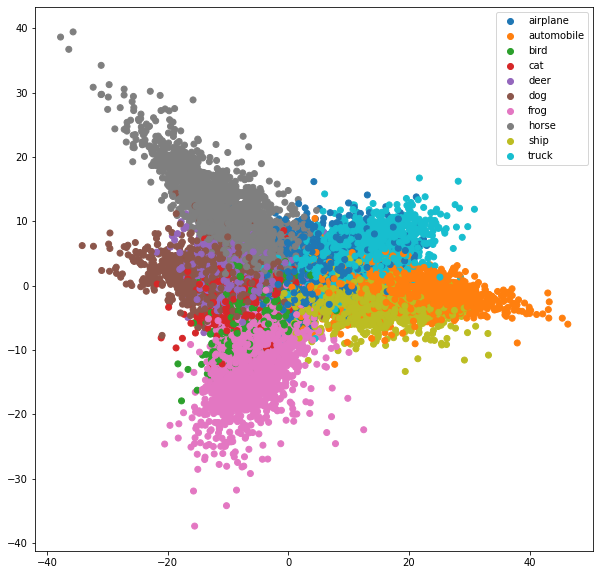

In [34]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

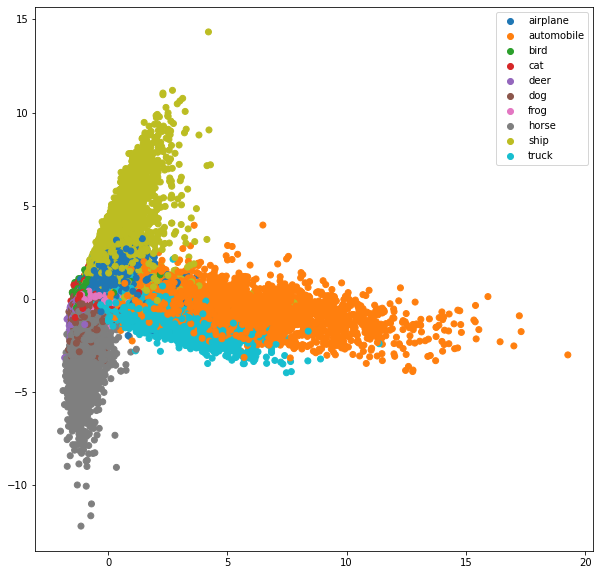

In [35]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels, classes)

We can do the same with the t-SNE algorithm. 

Again, we only use a subset of the data as t-SNE takes a considerable amount of time to compute.

We also see that the classes are more well separated in the output representations compared to the intermediate representations.

In [36]:
def get_tsne(data, n_components=2, n_images=None):

    if n_images is not None:
        data = data[:n_images]

    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

/home/allan/anaconda3/envs/py3torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/allan/anaconda3/envs/py3torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


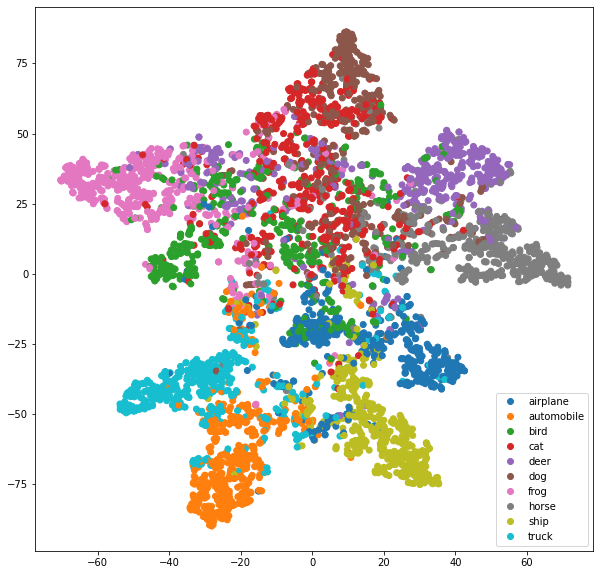

In [37]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, classes, n_images=N_IMAGES)

/home/allan/anaconda3/envs/py3torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/allan/anaconda3/envs/py3torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


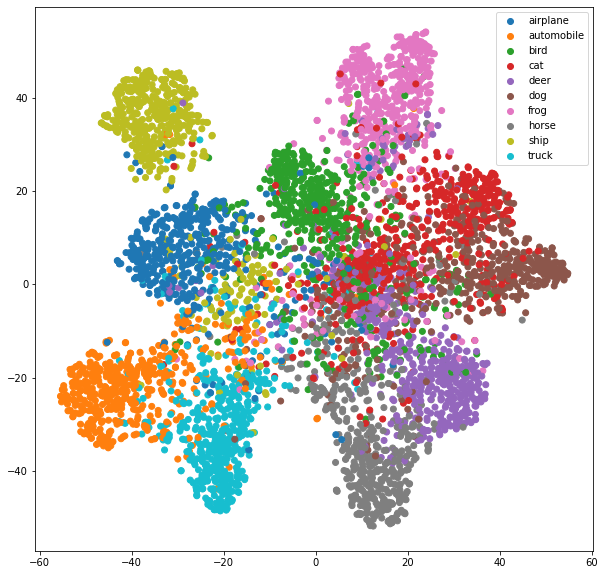

In [38]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, classes, n_images=N_IMAGES)

We can also imagine an image belonging to a specified class. 

Spoilers: this didn't work in the previous notebooks, won't work here, and won't work in the future. This is the last time we'll attempt to generate an image.

If you do know a simple method to generate images that look better than pure random noise, feel free to [submit an issue](https://github.com/bentrevett/pytorch-image-classification/issues) on how it is done and it can be added to these tutorials.

In [39]:
def imagine_image(model, classes, image, device, n_iterations=10_000):

    model.eval()

    label = classes.index(image)

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(256, 3, 32, 32).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, label], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

In [40]:
IMAGE = 'frog'

best_image, best_prob = imagine_image(model, classes, IMAGE, device)

  0%|          | 0/10000 [00:00<?, ?it/s]

We get an image that our model is ~100% confident is a frog, but just looks like random noise.

In [41]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

Best image probability: 100.00%


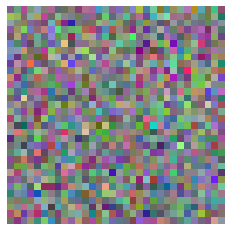

In [42]:
best_image = normalize_image(best_image)

plt.imshow(best_image.permute(1, 2, 0).cpu().numpy())
plt.axis('off');

Next, we'll plot some images after they have been convolved with the first convolutional layer.

In [43]:
def plot_filtered_images(images, filters, n_filters=None, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1, 2, 0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

    fig.subplots_adjust(hspace=-0.7)

We can see different types of edge detection and blurring that the filters have learned that are apparently decent feature extractors for this model and task.

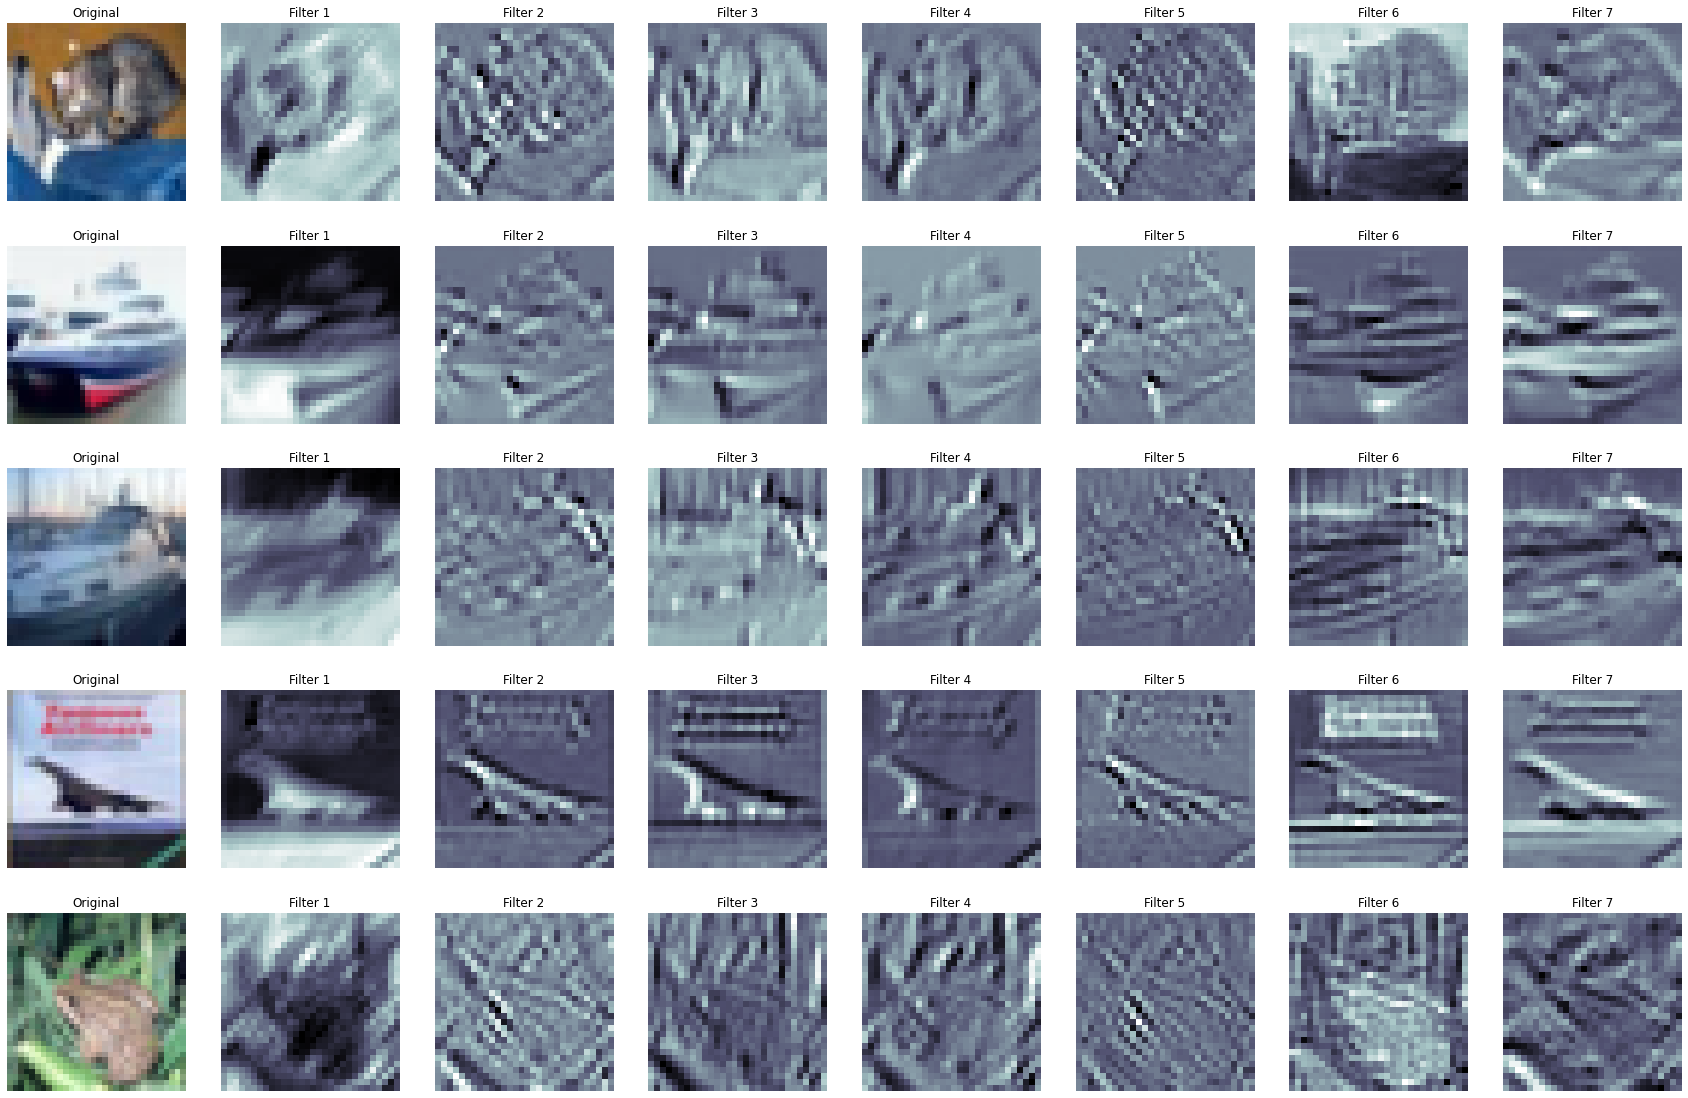

In [44]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)

Finally, we can plot the actual filters our model has learned.

In [45]:
def plot_filters(filters, normalize=True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize=(20, 10))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    fig.subplots_adjust(wspace=-0.9)

Again, nothing really interpretable here, sadly.

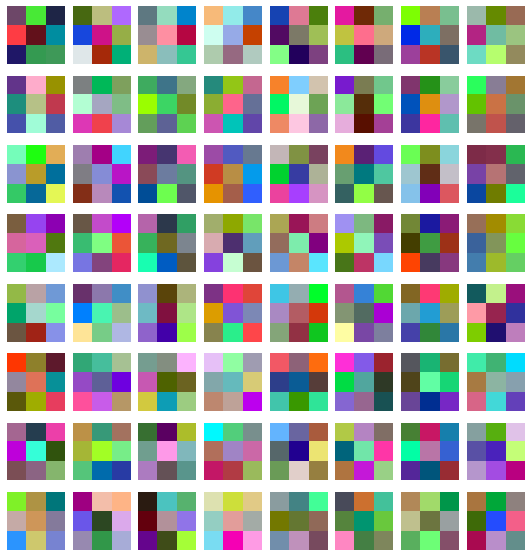

In [46]:
plot_filters(filters)

Can we ever learn interesting looking filters? Or are we doomed to just look at colorful blocks forever?

Well, we can take a *pre-trained* AlexNet model and view the filters of that. This pre-trained version of AlexNet was trained by people at PyTorch and was not trained on the CIFAR10 dataset, but on the [ILSVRC](https://arxiv.org/abs/1409.0575) dataset, usually just called the ImageNet dataset. ImageNet is a dataset with over 1 million images in 1,000 classes. Torchvision provides ways of downloading different models pre-trained on ImageNet, such as AlexNet and [many others](https://pytorch.org/vision/stable/models.html).  

First, we can import the model making sure to pass `pretrained = True` to get a pre-trained version. Torchvision will then import the model, download the weights for it and load them into the new model.

We can see that this is similar to our AlexNet model but has considerably more parameters.

One interesting thing is that they use much larger filters in the first convolutional layer - 11x11 instead of 3x3.

In [47]:
model = models.alexnet(pretrained=True)

print(model)

/home/allan/anaconda3/envs/py3torch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/allan/anaconda3/envs/py3torch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/allan/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

We can then get the learned values of these filters the same way we did for our version of AlexNet and then plot them.

As we can see the patterns are much more interesting, though still not really interpretable.

So how come it learned these interesting looking filters? Is it just because the filters are bigger? Is it because models can only do well on ImageNet if they learn more interesting filters? Or something else?

Do more interesting looking filters imply that they perform better? Or are these filters showing how the model has overfit to patterns on the images within ImageNet?

It is difficult to answer these questions as modern computer vision architectures now seem to favour smaller filter sizes with their largest filters being 5x5 - so maybe larger filters aren't that good after all?

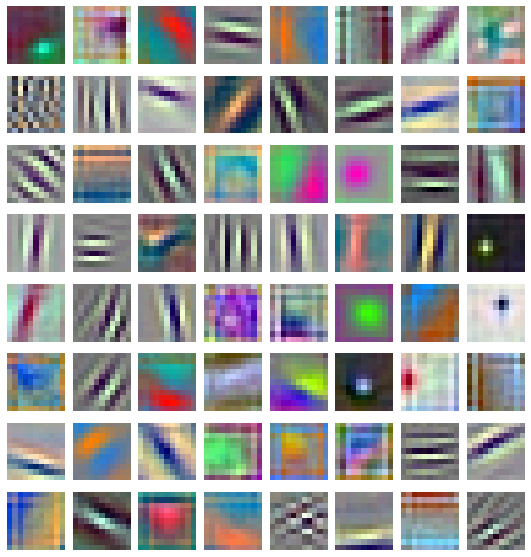

In [48]:
filters = model.features[0].weight.data

plot_filters(filters)